## Clustering Top 10 and Bottom 10 countries (2005-2014) 

This is for confirming their position when using average USD_CAP to rank. We are first filtering the original dataset to the years 2005-2014 where the data is most complete for most countries.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Loading the dataset and dropping FLAG_CODES
df = pd.read_csv('data/raw/pharma_spending_data.csv')
df = df.drop_duplicates()
df = df.drop(columns="FLAG_CODES")
df

,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,TOTAL_SPEND
0,AUS,1971,15.992,0.727,35.720,462.11
1,AUS,1972,15.091,0.686,36.056,475.11
2,AUS,1973,15.117,0.681,39.871,533.47
3,AUS,1974,14.771,0.755,47.559,652.65
4,AUS,1975,11.849,0.682,47.561,660.76
...,...,...,...,...,...,...
1031,LTU,2012,28.942,1.820,448.728,1340.70
1032,LTU,2013,28.173,1.728,461.178,1364.02
1033,LTU,2014,27.836,1.724,485.245,1422.92
1034,LTU,2015,26.784,1.745,504.422,1465.30


In [4]:
# Creating a new database that includes years 2005 to 2014 and dropping 4 countries that are missing too much data
df_decade_complete = df[(df['TIME'] >= 2005) & (df['TIME'] <= 2014)]
df_decade_complete = df_decade_complete[~df_decade_complete['LOCATION'].isin(['GBR', 'NZL', 'TUR', 'RUS'])]

# Defining the range of years and locations
years = pd.Series(range(2005, 2015), name="TIME")
locations = df_decade_complete['LOCATION'].drop_duplicates()

# Create all combinations of LOCATION and TIME
all_combinations = pd.merge(locations, years, how="cross")

# Merge with the original df_filtered to include all years for each location
df_decade_complete = pd.merge(
    all_combinations,
    df_decade_complete,
    on=["LOCATION", "TIME"],
    how="left"
)

df_decade_complete

,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,TOTAL_SPEND
0,AUS,2005,15.218,1.213,432.513,8821.02
1,AUS,2006,15.276,1.219,461.821,9558.72
2,AUS,2007,15.201,1.225,485.887,10119.86
3,AUS,2008,15.412,1.273,510.172,10840.75
4,AUS,2009,15.535,1.334,553.724,12011.21
...,...,...,...,...,...,...
315,LTU,2010,26.716,1.821,366.563,1135.35
316,LTU,2011,26.038,1.692,386.589,1170.64
317,LTU,2012,28.942,1.820,448.728,1340.70
318,LTU,2013,28.173,1.728,461.178,1364.02


In [5]:
# Checking for null values
df_decade_complete.isnull().sum()

LOCATION       0
TIME           0
PC_HEALTHXP    3
PC_GDP         3
USD_CAP        3
TOTAL_SPEND    3
dtype: int64

In [6]:
# Using forward fill to fill null values
df_decade_complete = df_decade_complete.sort_values(by=["LOCATION", "TIME"])
df_decade_complete = df_decade_complete = df_decade_complete.ffill()

print(df_decade_complete.isnull().sum())

LOCATION       0
TIME           0
PC_HEALTHXP    0
PC_GDP         0
USD_CAP        0
TOTAL_SPEND    0
dtype: int64


In [ ]:
# Export df_decade_complete to a CSV file
# df_decade_complete.to_csv("Pharma_Spending_2005_2014.csv", index=False)

After filtering the original dataset to the correct years and filling in empty rows, we will create a new dataset with the top 10 and bottom 10 countries based on the average spending per capita. From there, we will perform K-means clustering.

In [7]:
# Group by LOCATION and calculate the mean for each country
top_10_countries = df_decade_complete.groupby('LOCATION').mean().sort_values(by='USD_CAP', ascending=False).head(10).reset_index()
bottom_10_countries = df_decade_complete.groupby('LOCATION').mean().sort_values(by='USD_CAP', ascending=True).head(10).reset_index()

# Join top_10_countries & bottom_10_countries together
top_and_bottom_countries = pd.concat([top_10_countries, bottom_10_countries])
print(top_and_bottom_countries)
print(top_and_bottom_countries.shape[0])

  LOCATION    TIME  PC_HEALTHXP  PC_GDP   USD_CAP  TOTAL_SPEND
0      USA  2009.5      12.1171  1.9084  937.8955   288954.418
1      CAN  2009.5      17.9715  1.7740  720.3611    24445.745
2      CHE  2009.5      12.2824  1.3064  700.7456     5508.028
3      GRC  2009.5      26.7591  2.3890  658.0759     7266.228
4      JPN  2009.5      19.6365  1.8187  646.7647    82636.276
5      IRL  2009.5      15.1280  1.4058  635.7886     2858.381
6      DEU  2009.5      14.7916  1.5719  627.0213    51073.068
7      FRA  2009.5      16.3773  1.7227  617.5241    40066.831
8      BEL  2009.5      15.6147  1.5132  595.2560     6477.548
9      LUX  2009.5       9.4886  0.6326  573.4413      290.057
0      LVA  2009.5      24.8619  1.4204  269.1964      566.278
1      EST  2009.5      20.6810  1.1794  269.5759      358.804
2      MEX  2009.5      31.2677  1.8379  277.9795    32368.577
3      ISR  2009.5      13.2833  0.9560  300.1000     1933.890
4      POL  2009.5      24.8208  1.5318  304.3207    11

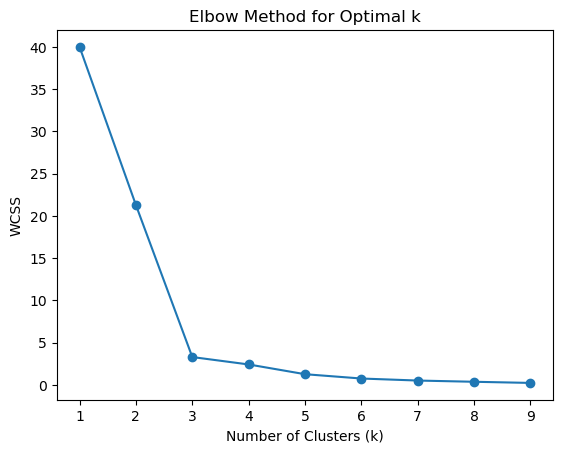

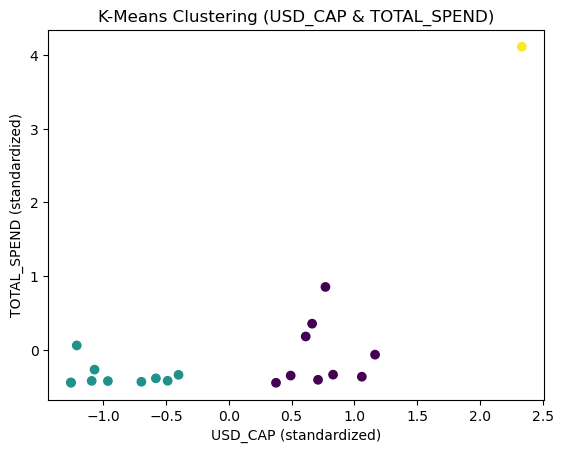

In [8]:
# Select relevant features for clustering
X = top_and_bottom_countries[['USD_CAP', 'TOTAL_SPEND']]

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Determine the optimal number of clusters using the Elbow Method
wcss = []
for k in range(1, 10): # 31 countries in total
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Create a DataFrame for WCSS values and print
#wcss_df = pd.DataFrame({'Number of Clusters': range(1, 10), 'WCSS': wcss})
#print(wcss_df)

# Plot the WCSS to find the elbow
plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k')
plt.show()

# Step 3: Fit K-Means with the chosen number of clusters
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
top_and_bottom_countries['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: Interpret and visualize
# Get cluster centroids
centroids = kmeans.cluster_centers_

# Plot clusters in 2D
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=top_and_bottom_countries['Cluster'], cmap='viridis', marker='o')
plt.xlabel('USD_CAP (standardized)')
plt.ylabel('TOTAL_SPEND (standardized)')
plt.title('K-Means Clustering (USD_CAP & TOTAL_SPEND)')
#plt.legend()
plt.show()

In [9]:
# Add cluster labels to the DataFrame
top_and_bottom_countries['Cluster'] = kmeans.labels_
top_and_bottom_countries

,LOCATION,TIME,PC_HEALTHXP,PC_GDP,USD_CAP,TOTAL_SPEND,Cluster
0,USA,2009.5,12.1171,1.9084,937.8955,288954.418,2
1,CAN,2009.5,17.9715,1.7740,720.3611,24445.745,0
2,CHE,2009.5,12.2824,1.3064,700.7456,5508.028,0
3,GRC,2009.5,26.7591,2.3890,658.0759,7266.228,0
4,JPN,2009.5,19.6365,1.8187,646.7647,82636.276,0
5,IRL,2009.5,15.1280,1.4058,635.7886,2858.381,0
6,DEU,2009.5,14.7916,1.5719,627.0213,51073.068,0
7,FRA,2009.5,16.3773,1.7227,617.5241,40066.831,0
8,BEL,2009.5,15.6147,1.5132,595.2560,6477.548,0
9,LUX,2009.5,9.4886,0.6326,573.4413,290.057,0


In [10]:
print(top_and_bottom_countries.groupby('Cluster')['LOCATION'].count())

Cluster
0     9
1    10
2     1
Name: LOCATION, dtype: int64


Visualizations of Clustering

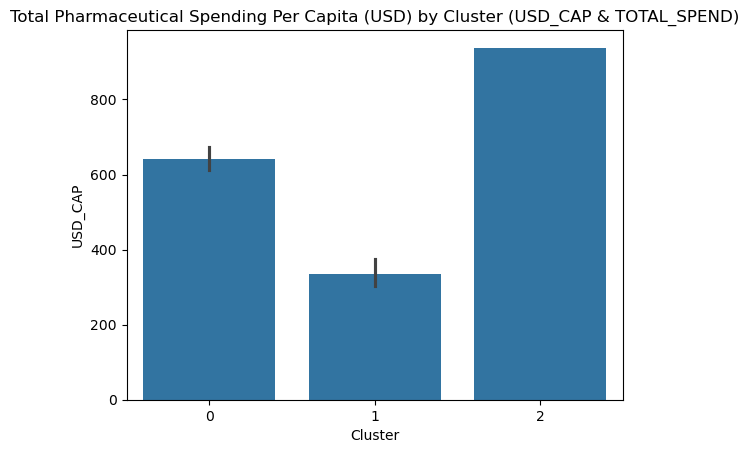

In [11]:
# Bar plot of USD_CAP by cluster
sns.barplot(x='Cluster', y='USD_CAP', data=top_and_bottom_countries)
plt.title('Total Pharmaceutical Spending Per Capita (USD) by Cluster (USD_CAP & TOTAL_SPEND)')
plt.show()

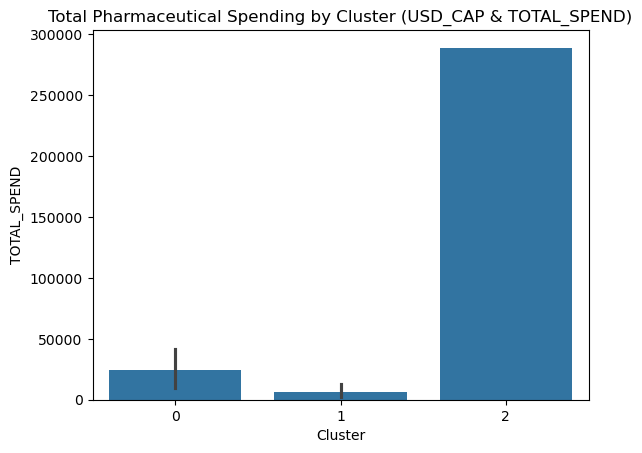

In [12]:
# Bar plot of TOTAL_SPEND by cluster
sns.barplot(x='Cluster', y='TOTAL_SPEND', data=top_and_bottom_countries)
plt.title('Total Pharmaceutical Spending by Cluster (USD_CAP & TOTAL_SPEND)')
plt.show()

From these 2 bar plots, we can make these observations:

Cluster 0 & 2: High spending countries <br>
Cluster 1: Bottom spending countries

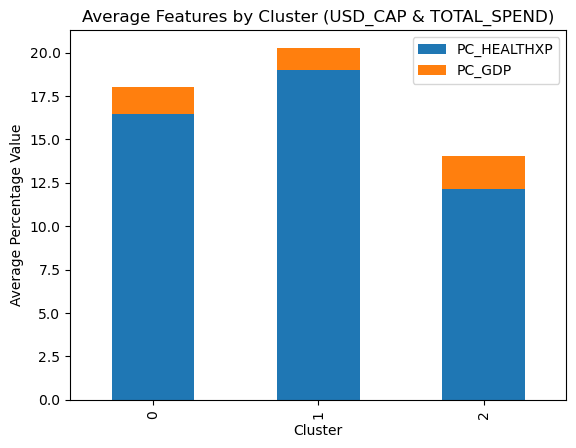

In [13]:
# Group by cluster and calculate the average of the features
avg_features_by_cluster = top_and_bottom_countries.groupby('Cluster')[['PC_HEALTHXP', 'PC_GDP']].mean().reset_index()

# Create a bar plot of the average of PC_HEALTHXP, PC_GDP by Cluster
avg_features_by_cluster.plot(x='Cluster', kind='bar', stacked=True)
plt.title('Average Features by Cluster (USD_CAP & TOTAL_SPEND)')
plt.ylabel('Average Percentage Value')
plt.show()

Interestingly in this stacked plot despite showing high spending, countries in cluster 0 and 2 spend less in pharmaceuticals in terms of percentage of healthcare expenditure. The countries in cluster 0 despite showing low spending, actually spend more in terms of percentage of healthcare expendtiture.

In [14]:
# Sort by cluster to group countries by cluster
country_clusters = top_and_bottom_countries.sort_values(by='Cluster')

# Create a dictionary grouping countries by cluster
cluster_groups = country_clusters.groupby('Cluster')['LOCATION'].apply(list)

# Print the grouped clusters
for cluster, countries in cluster_groups.items():
    print(f"Cluster {cluster}: {', '.join(countries)}")

Cluster 0: LUX, CAN, CHE, GRC, JPN, IRL, DEU, FRA, BEL
Cluster 1: CZE, LTU, DNK, POL, NLD, MEX, EST, LVA, NOR, ISR
Cluster 2: USA


# Summary

After clustering these 20 countries, they were categorized into 3 clusters. Cluster 0 confirms the top 10 spending countries ranked by average spend per capita. Cluster 1 confirms the bottom 10 spending countries ranked by average spend per capita. Cluster 3 contains only one country (USA), which according to average spend per capita is considered a top spending country. As shown on the cluster graph, USA is an outlier in terms of spending per capita and total spending therefore it's in a category of its own.

Many of the high-spending countries have strong economies with high GDP per capita, which allows them to spend more on drugs. Even if their pharmaceutical spending is low as a percentage of healthcare expenditure (PC_HEALTHXP), their high GDP amplifies their total spending, reflecting the wealth of these countries. Despite having the ability to spend more, they allocate a larger proportion of their healthcare resources to other areas, such as preventative care, outpatient services, and advanced technologies. Additionally, many of these countries regulate drug prices by negotiating directly with pharmaceutical companies or promoting the use of generics, further reducing the share of healthcare expenditure dedicated to pharmaceuticals. These factors illustrate how these countries maintain efficient healthcare systems while keeping pharmaceutical costs relatively low as a proportion of health expenditure.

For the low-spending countries, there’s a mix of those with low GDPs and those with higher GDP per capita. Countries with lower GDPs have less to spend and may underfund their healthcare systems, resulting in a reliance on pharmaceutical drugs to meet healthcare needs. This reliance leads to higher pharmaceutical spending as a percentage of healthcare expenditure (PC_HEALTHXP), even though their overall healthcare spending as a share of GDP (PC_GDP) remains low. On the other hand, countries with higher GDPs, such as the Nordic countries, have robust healthcare systems that emphasize preventative care and public health programs, reducing their reliance on drugs. Nevertheless, their wealth enables them to spend more on pharmaceuticals as a share of healthcare expenditure, reflecting their capacity to invest in diverse healthcare priorities.

Finally for the USA, their outlier status is influenced by the privatization of their healthcare system.

If we had more time, we could look at each country and investigate the economic and social factors that influence their spending patterns on pharmaceutical drugs.From clustering these 20 countries, they were categorized into 3 clusters. Cluster 0 confirms the top 10 spending countries ranked by average spend per capita. Cluster 1 confirms the bottom 10 spending countries ranked by average spend per capita. Cluster 3 contains only one country (USA), which according to average spend per capita is considered a top spending country. As shown on the cluster graph, USA is an outlier in terms of spending per capita and total spending therefore it's in a category of its own.